# OSM Highway Extraction Example

This notebook demonstrates how to extract highway networks from OpenStreetMap
using the OSM Highways processor.

## Features
- Download regional OSM data from Geofabrik
- Extract highways for any AOI
- Filter by highway type
- Export to multiple formats
- Track data freshness

In [1]:
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt

from geoworkflow.processors.extraction.osm_highways import OSMHighwaysProcessor
from geoworkflow.schemas.osm_highways_config import OSMHighwaysConfig
from geoworkflow.utils.geofabrik_utils import list_cached_pbfs

import logging
logging.getLogger('geoworkflow').setLevel(logging.DEBUG)

## Example 1: Basic Extraction

Extract all highways for a city AOI.

In [5]:
# Setup paths
aoi_file = Path("../data/aoi/accra_aoi.geojson")

output_dir = Path("../data/01_extracted/accra_highways")
output_dir.mkdir(parents=True, exist_ok=True)

# Create config
config = OSMHighwaysConfig(
    aoi_file=aoi_file,
    output_dir=output_dir,
    highway_types="all",  # Extract all highway types
    include_attributes=["highway", "name", "surface", "lanes"],
    export_format="geojson",
    force_redownload= True,
    max_cache_age_days=30  # Warn if data >30 days old
)

# Run extraction
processor = OSMHighwaysProcessor(config)
result = processor.process()

print(f"Success: {result.success}")
print(f"Extracted: {result.processed_count} highway segments")
print(f"Output: {processor.output_file}")

2025-10-25 12:15:37,570 - geoworkflow.OSMHighwaysProcessor - INFO - Starting OSMHighwaysProcessor processing
2025-10-25 12:15:37,570 - geoworkflow.OSMHighwaysProcessor - DEBUG - Step 1: Validating inputs
2025-10-25 12:15:37,687 - geoworkflow.OSMHighwaysProcessor - DEBUG - Step 2: Setting up processing
2025-10-25 12:15:37,688 - geoworkflow.utils.resource_utils - DEBUG - Created temporary directory: /var/folders/j7/4yg5r60j1y9dl19_fw6t4v_m0000gn/T/osmhighwaysprocessor_le0cjjyv
2025-10-25 12:15:37,688 - geoworkflow.OSMHighwaysProcessor - DEBUG - Created temporary directory: /var/folders/j7/4yg5r60j1y9dl19_fw6t4v_m0000gn/T/osmhighwaysprocessor_le0cjjyv
2025-10-25 12:15:37,689 - geoworkflow.OSMHighwaysProcessor - INFO - Loading AOI from ../data/aoi/accra_aoi.geojson
2025-10-25 12:15:37,787 - geoworkflow.OSMHighwaysProcessor - INFO - Reprojecting AOI from PROJCS["Africa_Equidistant_Conic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHO

Success: True
Extracted: 0 highway segments
Output: ../data/01_extracted/accra_highways/highways_ghana_accra_aoi_20251025_122501.geojson


## Example 2: Major Roads Only

Extract only major roads (motorway through tertiary).

In [7]:
config_major = OSMHighwaysConfig(
    aoi_file=aoi_file,
    output_dir=output_dir,
    highway_types=["motorway", "trunk", "primary", "secondary", "tertiary"],
    include_attributes=["highway", "name", "ref", "maxspeed"],
    export_format="geojson"
)

processor_major = OSMHighwaysProcessor(config_major)
result_major = processor_major.process()

print(f"Major roads extracted: {result_major.processed_count}")

2025-10-25 12:27:02,980 - geoworkflow.OSMHighwaysProcessor - INFO - Starting OSMHighwaysProcessor processing
2025-10-25 12:27:02,980 - geoworkflow.OSMHighwaysProcessor - DEBUG - Step 1: Validating inputs
2025-10-25 12:27:03,075 - geoworkflow.OSMHighwaysProcessor - DEBUG - Step 2: Setting up processing
2025-10-25 12:27:03,076 - geoworkflow.utils.resource_utils - DEBUG - Created temporary directory: /var/folders/j7/4yg5r60j1y9dl19_fw6t4v_m0000gn/T/osmhighwaysprocessor_r2zyry83
2025-10-25 12:27:03,076 - geoworkflow.OSMHighwaysProcessor - DEBUG - Created temporary directory: /var/folders/j7/4yg5r60j1y9dl19_fw6t4v_m0000gn/T/osmhighwaysprocessor_r2zyry83
2025-10-25 12:27:03,077 - geoworkflow.OSMHighwaysProcessor - INFO - Loading AOI from ../data/aoi/accra_aoi.geojson
2025-10-25 12:27:03,172 - geoworkflow.OSMHighwaysProcessor - INFO - Reprojecting AOI from PROJCS["Africa_Equidistant_Conic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHO

Major roads extracted: 0


## Example 3: Visualize Results

2025-10-25 12:29:56,099 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-10-25 12:29:56,100 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-10-25 12:29:56,104 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-10-25 12:29:56,105 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/Users/juancheeto/miniconda3/envs/geoworkflow/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
2025-10-25 12:29:56,105 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/Users/juancheeto/miniconda3/envs/geoworkflow/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif

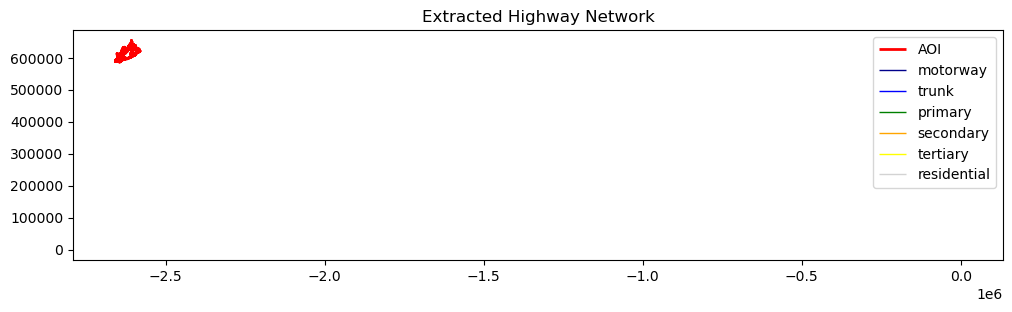

In [8]:
# Load results
highways = gpd.read_file(processor.output_file)
aoi = gpd.read_file(aoi_file)

# Plot
fig, ax = plt.subplots(figsize=(12, 12))
aoi.boundary.plot(ax=ax, color='red', linewidth=2, label='AOI')

# Color by highway type
highway_colors = {
    'motorway': 'darkblue',
    'trunk': 'blue',
    'primary': 'green',
    'secondary': 'orange',
    'tertiary': 'yellow',
    'residential': 'lightgray'
}

for htype, color in highway_colors.items():
    subset = highways[highways['highway'] == htype]
    if len(subset) > 0:
        subset.plot(ax=ax, color=color, linewidth=1, label=htype)

plt.legend()
plt.title("Extracted Highway Network")
plt.show()

## Example 4: Check Cache Status

In [9]:
cache_dir = Path.home() / ".geoworkflow" / "osm_cache"

print("Cached PBF files:")
for region, meta in list_cached_pbfs(cache_dir):
    print(f"  {region}: {meta.file_size_mb:.1f} MB, {meta.age_days()} days old")
    print(f"    Downloaded: {meta.download_date}")
    print(f"    Source: {meta.geofabrik_url}")

Cached PBF files:
  ghana: 101.7 MB, 0 days old
    Downloaded: 2025-10-25 12:15:45.580543
    Source: https://download.geofabrik.de/africa/ghana-latest.osm.pbf
  south-africa: 361.5 MB, 1 days old
    Downloaded: 2025-10-24 08:55:16.303009
    Source: https://download.geofabrik.de/africa/south-africa-latest.osm.pbf
  kenya: 310.6 MB, 1 days old
    Downloaded: 2025-10-23 20:10:40.772895
    Source: https://download.geofabrik.de/africa/kenya-latest.osm.pbf
